<a href="https://colab.research.google.com/github/JeremyBorden/Fall-2024-Biodiversity/blob/main/Occupancy_modeling_with_SpOccupancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a occupancy model for the species *Lipaugus vociferans* using the SpOccupancy package in R. We model the occupancy across multiple seasons - each season is a year between 2012 and 2020. We then use this model to make predictions for the occupancy in 2021.

We use **occupancy covariates** such as: precipitation, temperature, EVI (enhanced vegetation index), and tree cover

and **detection covariates** such as: observation_date, number_observers, effort_hours, year, and hours_of_day for this model.

The SpOccupancy package in R is provided by Doser Lab and is documented here

https://doserlab.com/files/spoccupancy-web/

In [1]:
install.packages("spOccupancy")
install.packages("stars")
install.packages("readr")
install.packages(c('quantmod','ff','foreign','R.matlab'),dependency=T)
suppressPackageStartupMessages(library(tidyverse))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(spOccupancy)
library(coda)
library(stars)
library(ggplot2)
set.seed(102)
library(dplyr)
library(lubridate)

Loading required package: abind

Loading required package: sf

Linking to GEOS 3.11.1, GDAL 3.6.4, PROJ 9.1.1; sf_use_s2() is TRUE



In [3]:
ebird_data <- read_csv("/content/ebird_with_climate_data.csv", show_col_types = FALSE)
head(ebird_data, 10)

New names:
• `` -> `...1`


...1,Join_Count,TARGET_FID,checklist_id,state_code,locality_id,latitude,longitude,observation_date,protocol_type,⋯,Site_ID_1,OBJECTID,Shape_Length,Shape_Area,Site_ID,X_coord,Y_coord,tmax,tmin,prec
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,1,S119120564,BR-AM,L10805344,-3.003331,-59.93964,9/20/2022,Stationary,⋯,69,69,556437.7,18673891086,69,-59.70532,-3.261773,NaN,NaN,NaN
1,1,2,S119120564,BR-AM,L10805344,-3.003331,-59.93964,9/20/2022,Stationary,⋯,69,69,556437.7,18673891086,69,-59.70532,-3.261773,NaN,NaN,NaN
2,1,3,S119120564,BR-AM,L10805344,-3.003331,-59.93964,9/20/2022,Stationary,⋯,69,69,556437.7,18673891086,69,-59.70532,-3.261773,NaN,NaN,NaN
3,1,4,S119120564,BR-AM,L10805344,-3.003331,-59.93964,9/20/2022,Stationary,⋯,69,69,556437.7,18673891086,69,-59.70532,-3.261773,NaN,NaN,NaN
4,1,5,S119120564,BR-AM,L10805344,-3.003331,-59.93964,9/20/2022,Stationary,⋯,69,69,556437.7,18673891086,69,-59.70532,-3.261773,NaN,NaN,NaN
5,1,6,S119120564,BR-AM,L10805344,-3.003331,-59.93964,9/20/2022,Stationary,⋯,69,69,556437.7,18673891086,69,-59.70532,-3.261773,NaN,NaN,NaN
6,1,7,S119120564,BR-AM,L10805344,-3.003331,-59.93964,9/20/2022,Stationary,⋯,69,69,556437.7,18673891086,69,-59.70532,-3.261773,NaN,NaN,NaN
7,1,8,S119120564,BR-AM,L10805344,-3.003331,-59.93964,9/20/2022,Stationary,⋯,69,69,556437.7,18673891086,69,-59.70532,-3.261773,NaN,NaN,NaN
8,1,9,S119120564,BR-AM,L10805344,-3.003331,-59.93964,9/20/2022,Stationary,⋯,69,69,556437.7,18673891086,69,-59.70532,-3.261773,NaN,NaN,NaN


In [4]:
str(ebird_data)

spc_tbl_ [267,407 × 45] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ ...1              : num [1:267407] 0 1 2 3 4 5 6 7 8 9 ...
 $ Join_Count        : num [1:267407] 1 1 1 1 1 1 1 1 1 1 ...
 $ TARGET_FID        : num [1:267407] 1 2 3 4 5 6 7 8 9 10 ...
 $ checklist_id      : chr [1:267407] "S119120564" "S119120564" "S119120564" "S119120564" ...
 $ state_code        : chr [1:267407] "BR-AM" "BR-AM" "BR-AM" "BR-AM" ...
 $ locality_id       : chr [1:267407] "L10805344" "L10805344" "L10805344" "L10805344" ...
 $ latitude          : num [1:267407] -3 -3 -3 -3 -3 ...
 $ longitude         : num [1:267407] -59.9 -59.9 -59.9 -59.9 -59.9 ...
 $ observation_date  : chr [1:267407] "9/20/2022" "9/20/2022" "9/20/2022" "9/20/2022" ...
 $ protocol_type     : chr [1:267407] "Stationary" "Stationary" "Stationary" "Stationary" ...
 $ duration_minutes  : num [1:267407] 190 190 190 190 190 190 190 190 190 190 ...
 $ effort_distance_km: num [1:267407] 0 0 0 0 0 0 0 0 0 0 ...
 $ number_observers  : num [1:2674

In [5]:
manaus_birds <-subset(ebird_data, Site_ID %in% c(68, 69, 78, 79) & year %in% c(2012:2021))
#sorting the data frame by observation date
manaus_birds <- manaus_birds[order(as.Date(manaus_birds$observation_date, format="%m/%d/%Y")),]
li_vo <-subset(manaus_birds, scientific_name == "Lipaugus vociferans")

In [6]:
str(manaus_birds)

tibble [94,136 × 45] (S3: tbl_df/tbl/data.frame)
 $ ...1              : num [1:94136] 93667 93668 93669 93670 93671 ...
 $ Join_Count        : num [1:94136] 1 1 1 1 1 1 1 1 1 1 ...
 $ TARGET_FID        : num [1:94136] 93669 93670 93671 93672 93673 ...
 $ checklist_id      : chr [1:94136] "S130090237" "S130090237" "S130090237" "S130090237" ...
 $ state_code        : chr [1:94136] "BR-AM" "BR-AM" "BR-AM" "BR-AM" ...
 $ locality_id       : chr [1:94136] "L2872043" "L2872043" "L2872043" "L2872043" ...
 $ latitude          : num [1:94136] -3.06 -3.06 -3.06 -3.06 -3.06 ...
 $ longitude         : num [1:94136] -60.1 -60.1 -60.1 -60.1 -60.1 ...
 $ observation_date  : chr [1:94136] "2/11/2012" "2/11/2012" "2/11/2012" "2/11/2012" ...
 $ protocol_type     : chr [1:94136] "Traveling" "Traveling" "Traveling" "Traveling" ...
 $ duration_minutes  : num [1:94136] 60 60 60 60 60 60 60 60 60 60 ...
 $ effort_distance_km: num [1:94136] 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ number_observers  : nu

# Creating replicates from Site ID, year, and checklist ID

In [7]:
#creating a unique replicate for every site_id, year, and checklist_id combination

li_vo <- li_vo %>%
  group_by(Site_ID, year) %>%
  mutate(replicate = dense_rank(checklist_id)) %>%
  ungroup()

In [8]:
tail(li_vo[c("replicate", "Site_ID", "checklist_id")], 100)

replicate,Site_ID,checklist_id
<int>,<dbl>,<chr>
468,69,S98255198
470,69,S98271420
472,69,S98291938
469,69,S98271373
471,69,S98271427
473,69,S98295325
476,69,S98333270
474,69,S98308682
475,69,S98308987


In [9]:
str(li_vo)

tibble [3,928 × 46] (S3: tbl_df/tbl/data.frame)
 $ ...1              : num [1:3928] 93679 93661 93600 93619 90641 ...
 $ Join_Count        : num [1:3928] 1 1 1 1 1 1 1 1 1 1 ...
 $ TARGET_FID        : num [1:3928] 93681 93663 93602 93621 90643 ...
 $ checklist_id      : chr [1:3928] "S130090237" "S130091062" "S130167103" "S130170936" ...
 $ state_code        : chr [1:3928] "BR-AM" "BR-AM" "BR-AM" "BR-AM" ...
 $ locality_id       : chr [1:3928] "L2872043" "L2872043" "L22909033" "L22909335" ...
 $ latitude          : num [1:3928] -3.06 -3.06 -1.93 -2.62 -2.64 ...
 $ longitude         : num [1:3928] -60.1 -60.1 -61.4 -60.9 -60.9 ...
 $ observation_date  : chr [1:3928] "2/11/2012" "2/12/2012" "2/19/2012" "2/20/2012" ...
 $ protocol_type     : chr [1:3928] "Traveling" "Traveling" "Traveling" "Traveling" ...
 $ duration_minutes  : num [1:3928] 60 60 360 360 20 20 4 120 98 65 ...
 $ effort_distance_km: num [1:3928] 0.5 0.5 10 10 0.161 ...
 $ number_observers  : num [1:3928] 6 6 8 8 1 2 1 8 1 

In [10]:
tail(li_vo, 10)

...1,Join_Count,TARGET_FID,checklist_id,state_code,locality_id,latitude,longitude,observation_date,protocol_type,⋯,OBJECTID,Shape_Length,Shape_Area,Site_ID,X_coord,Y_coord,tmax,tmin,prec,replicate
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
267278,1,267280,G7628517,BR-AM,L5489684,-3.048641,-60.10232,12/29/2021,Traveling,⋯,69,556437.7,18673891086,69,-59.70532,-3.261773,30,24,219.01,67
188802,1,188804,S99675903,BR-AM,L10050564,-3.096594,-60.04863,12/30/2021,Traveling,⋯,69,556437.7,18673891086,69,-59.70532,-3.261773,30,24,219.01,533
267302,1,267304,G7628514,BR-AM,L1282183,-2.585630,-60.11382,12/30/2021,Stationary,⋯,79,556437.7,18673891102,79,-59.70532,-2.247187,30,24,189.86,47
267326,1,267328,G7628513,BR-AM,L8293073,-2.552963,-60.08073,12/30/2021,Traveling,⋯,79,556437.7,18673891102,79,-59.70532,-2.247187,30,24,189.86,46
267350,1,267352,G7628512,BR-AM,L3920538,-2.588512,-60.03445,12/30/2021,Stationary,⋯,79,556437.7,18673891102,79,-59.70532,-2.247187,30,24,189.86,45
267374,1,267376,G7628509,BR-AM,L3920538,-2.588512,-60.03445,12/30/2021,Traveling,⋯,79,556437.7,18673891102,79,-59.70532,-2.247187,30,24,189.86,44
267398,1,267400,G7628508,BR-AM,L17255598,-2.579768,-60.03518,12/30/2021,Traveling,⋯,79,556437.7,18673891102,79,-59.70532,-2.247187,30,24,189.86,43
188697,1,188699,S99743397,BR-AM,L10050564,-3.096594,-60.04863,12/31/2021,Traveling,⋯,69,556437.7,18673891086,69,-59.70532,-3.261773,30,24,219.01,534
198944,1,198946,S99778039,BR-AM,L8910319,-3.076123,-59.97923,12/31/2021,Stationary,⋯,69,556437.7,18673891086,69,-59.70532,-3.261773,30,24,219.01,535


In [11]:
table(li_vo$species_observed)


FALSE  TRUE 
 3281   647 

## Extracting detection non-detection data
 (following https://doserlab.com/files/spoccupancy-web/articles/dataformatting)

In [12]:
sites <- c(68, 69, 78, 79)
years <- 2012:2021

# Create an empty matrix to store the results
results_matrix <- matrix(0, nrow = length(sites), ncol = length(years),
                        dimnames = list(sites, years))

for (p in sites) {
  for (q in years) {
    # Calculate number of unique replicates
    num_replicates <- length(unique(li_vo$replicate[li_vo$Site_ID == p & li_vo$year == q]))

    # Store the result in the matrix
    results_matrix[as.character(p), as.character(q)] <- num_replicates
  }
}

# Print the results matrix
print("The number of replicates of Lipaugus vociferans per site and year is tabulated below:")
print(results_matrix)

[1] "The number of replicates of Lipaugus vociferans per site and year is tabulated below:"
   2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
68    3    1    2   23   25   21   28   21   15   35
69   60   40   42  197   94  209  270  558  386  538
78   28   10    1   56   89  153   62   77   12   34
79   33   38   16   85   69  116  118  230   54   79


In [13]:
y.long <- li_vo %>%
  group_by(Site_ID, year, replicate) %>%
  summarize(count = n(), species_observed, observation_date) %>%
  ungroup() %>%
  glimpse()

`summarise()` has grouped output by 'Site_ID', 'year'. You can override using
the `.groups` argument.


Rows: 3,928
Columns: 6
$ Site_ID          <dbl> 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 6…
$ year             <dbl> 2012, 2012, 2012, 2013, 2014, 2014, 2015, 2015, 2015,…
$ replicate        <int> 1, 2, 3, 1, 1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, …
$ count            <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ species_observed <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS…
$ observation_date <chr> "12/23/2012", "12/23/2012", "11/30/2012", "8/31/2013"…


In [14]:
# Plot (site) codes.
plot.codes <- sort(unique(y.long$Site_ID))
# Maximum number of replicates at a site
K <- length(unique(li_vo$replicate[li_vo$Site_ID == 69 & li_vo$year == 2021]))
# Number of sites
I<- length(unique(y.long$Site_ID))
# Number of years
J <- length(2012:2021)
# Array for detection-nondetection data.
y<- array(NA, dim = c(I, J, K))
# Label the dimensions of y (not necessary, but helpful)
dimnames(y)[[1]] <- plot.codes
# Look at the structure of our array y
str(y)

 logi [1:4, 1:10, 1:538] NA NA NA NA NA NA ...
 - attr(*, "dimnames")=List of 3
  ..$ : chr [1:4] "68" "69" "78" "79"
  ..$ : NULL
  ..$ : NULL


In [15]:
for (i in 1:I) { # Loop through sites.
  for(j in 1:J){#Loop through years from 2012 to 2020
    for (k in 1:K) { # Loop through replicates at each site.
      # Extract data for current site/year/replicate combination.
      curr.df <- y.long %>%
        filter(Site_ID == plot.codes[i], year == 2011+j, replicate == k)
      # Check if more than one date for a given replicate
      if (n_distinct(curr.df$observation_date) > 1) {
        # If there is more than 1 date, only use the data
        # from the first date.
        curr.dates <- unique(sort(curr.df$observation_date))
        curr.df <- curr.df %>%
          filter(observation_date == curr.dates[1])
      }
      # If plot i was sampled during year j and replicate k,
      # curr.df will have at least 1 row (i.e., at least
      # one species will be observed). If not, assume it
      # was not sampled for that replicate.
      if (nrow(curr.df) > 0) {
        if(curr.df$species_observed == TRUE){
          y[i, j, k] <- 1
        }
        if(curr.df$species_observed == FALSE){
          y[i, j, k] <- 0
        }
      }
      else{
        y[i, j, k] <-NA
      }
    } # k (replicates)
  }#j(years)
} # i (sites)

In [16]:
# Total number of observations for each site
length(y)
print("The number of detections of Lipaugus vociferans across the different sites is:")
apply(y, 1, sum, na.rm = TRUE)
print("The number of detections of Lipaugus vociferans across the different years is:")
apply(y, 2, sum, na.rm = TRUE)

print(paste0("The number of total detections across all sites and years is: ", sum(y == 1, na.rm = TRUE)))
print(paste0("The number of total non-detections across all sites and years is: ", sum(y == 0, na.rm = TRUE)))
print(paste0("The number of NA values in the detection non-detection data across sites, years and replicates is:", sum(is.na(y))))

[1] 21520

[1] "The number of detections of Lipaugus vociferans across the different sites is:"


68  69  78  79 
 35 213  96 302

[1] "The number of detections of Lipaugus vociferans across the different years is:"


[1]  13  18  11  85  41 108 108 147  64  51

[1] "The number of total detections across all sites and years is: 646"
[1] "The number of total non-detections across all sites and years is: 3262"
[1] "The number of NA values in the detection non-detection data across sites, years and replicates is:17612"


### Formatting the detection covariates into a 3D sites x years x replicates array
(following https://doserlab.com/files/spoccupancy-web/articles/dataformatting)

In [17]:
det.covs.df <- li_vo %>%
  group_by(Site_ID, year, replicate) %>%
  summarize(doy = unique(day_of_year),
            tod = unique(hours_of_day),
            n.obs = unique(number_observers),
            effort = unique(effort_hours)
            ) %>%
  ungroup() %>%
  glimpse()


`summarise()` has grouped output by 'Site_ID', 'year'. You can override using
the `.groups` argument.


Rows: 3,928
Columns: 7
$ Site_ID   <dbl> 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, …
$ year      <dbl> 2012, 2012, 2012, 2013, 2014, 2014, 2015, 2015, 2015, 2015, …
$ replicate <int> 1, 2, 3, 1, 1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…
$ doy       <dbl> 358, 358, 335, 243, 229, 310, 119, 270, 10, 11, 11, 11, 12, …
$ tod       <dbl> 18.00000, 18.00000, 6.50000, 6.50000, 13.50000, 6.00000, 17.…
$ n.obs     <dbl> 2, 2, 1, 1, 1, 2, 6, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, …
$ effort    <dbl> 1.5000000, 1.5000000, 4.0000000, 6.0000000, 0.3333333, 6.000…


In [18]:
livo.doy <- array(NA, dim = c(I, J, K))
livo.tod <- array(NA, dim = c(I, J, K))
livo.n.obs <- array(NA, dim = c(I, J, K))
livo.effort <- array(NA, dim = c(I, J, K))


In [19]:
for (i in 1:I) { # Loop through sites
  for(j in 1:J){#Loop through years from 2012 to 2020
    for (k in 1:K) { # Loop through replicate surveys
      # Get detection covariates for each survey/replicate
      curr.vals <- det.covs.df %>%
        filter(Site_ID == plot.codes[i], year == 2011+j, replicate == k) %>%
        select(doy, tod, n.obs, effort) %>%
        arrange(doy)
      # If the site was surveyed multiple times for the given replicate and year,
      # extract the first date and time value.
      if (nrow(curr.vals) > 0) {
        livo.doy[i, j, k] <- curr.vals$doy[1]
        livo.tod[i,j, k] <- curr.vals$tod[1]
        livo.n.obs[i, j, k] <- curr.vals$n.obs[1]
        livo.effort[i, j, k] <- curr.vals$effort[1]
      }
      else{
        livo.doy[i, j, k] <- NA
        livo.tod[i, j, k] <- NA
        livo.n.obs[i, j, k] <- NA
        livo.effort[i, j, k] <- NA
      }
    } # k (replicates)
  }#j(years)
} # i (sites)
# Check out the structure of our covariates.

In [20]:
str(livo.doy)
str(livo.tod)
str(livo.n.obs)
str(livo.effort)
sum(is.na(livo.doy))
sum(is.na(livo.tod))
sum(is.na(livo.n.obs))
sum(is.na(livo.effort))

 num [1:4, 1:10, 1:538] 358 198 191 266 243 249 306 247 229 275 ...
 num [1:4, 1:10, 1:538] 18 15 16.3 13 6.5 ...
 num [1:4, 1:10, 1:538] 2 2 1 5 1 1 4 1 1 2 ...
 num [1:4, 1:10, 1:538] 1.5 1 0.333 0.5 6 ...


[1] 17612

[1] 17612

[1] 17612

[1] 17612

In [21]:
if(sum(is.na(livo.effort))== sum(is.na(y))){
  print("Yaaay")
} else{
  print("Nay")
}

[1] "Yaaay"


Notice that number of NAs in y.train and det.covs agrees so we can pass this to the SpOccupancy model

In [22]:
#Create list of detection covariates
det.covs <- list(doy = livo.doy,
                 tod = livo.tod,
                 n.obs = livo.n.obs,
                 effort = livo.effort)
str(det.covs)

List of 4
 $ doy   : num [1:4, 1:10, 1:538] 358 198 191 266 243 249 306 247 229 275 ...
 $ tod   : num [1:4, 1:10, 1:538] 18 15 16.3 13 6.5 ...
 $ n.obs : num [1:4, 1:10, 1:538] 2 2 1 5 1 1 4 1 1 2 ...
 $ effort: num [1:4, 1:10, 1:538] 1.5 1 0.333 0.5 6 ...


## Formatting the occupancy covariates as a sites x years matrix

In [23]:
occ.covs.df <- li_vo %>%
  group_by(Site_ID, year) %>%
  reframe(precip = prec,
            tmin = tmin,
            tmax = tmax,
            ) %>%
  glimpse()

Rows: 3,928
Columns: 5
$ Site_ID <dbl> 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68…
$ year    <dbl> 2012, 2012, 2012, 2013, 2014, 2014, 2015, 2015, 2015, 2015, 20…
$ precip  <dbl> 208.54, 300.97, 300.97, 68.91, 68.26, 204.93, 307.01, 307.01, …
$ tmin    <dbl> 24.06, 23.62, 23.62, 24.00, 23.81, 24.12, 23.50, 23.50, 23.50,…
$ tmax    <dbl> 33.00, 31.00, 31.00, 32.00, 32.38, 32.00, 31.00, 31.00, 31.00,…


In [24]:
forest.df <- read_csv("/content/ForestSpecialist2.csv")
forest.df <- forest.df %>% filter ((Site_ID %in% sites & year %in% c(2012:2021)))

Rows: 11021 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): scientific_name
dbl (9): observation_count, Site_ID, year, X_coord, Y_coord, Observed, EVI, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [25]:
str(forest.df)

spc_tbl_ [3,928 × 10] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ scientific_name                  : chr [1:3928] "Lipaugus vociferans" "Lipaugus vociferans" "Lipaugus vociferans" "Lipaugus vociferans" ...
 $ observation_count                : num [1:3928] 0 0 0 0 3 0 0 0 0 0 ...
 $ Site_ID                          : num [1:3928] 79 79 79 78 78 78 78 78 78 78 ...
 $ year                             : num [1:3928] 2012 2012 2012 2012 2012 ...
 $ X_coord                          : num [1:3928] -59.7 -59.7 -59.7 -61.2 -61.2 ...
 $ Y_coord                          : num [1:3928] -2.25 -2.25 -2.25 -2.25 -2.25 ...
 $ Observed                         : num [1:3928] 0 0 0 0 1 0 0 0 0 0 ...
 $ EVI                              : num [1:3928] 0.473 0.473 0.473 0.469 0.469 ...
 $ umd_tree_cover_loss_ha           : num [1:3928] 163604 163604 163604 163604 163604 ...
 $ umd_tree_cover_loss_from_fires_ha: num [1:3928] 25449 25449 25449 25449 25449 ...
 - attr(*, "spec")=
  .. cols(
  ..   scientific_n

In [26]:
livo.precip <- array(NA, dim = c(I, J))
livo.tmin <- array(NA, dim = c(I, J))
livo.tmax <- array(NA, dim = c(I, J))
livo.evi <- array(NA, dim = c(I, J))
livo.umdha <- array(NA, dim = c(I, J))
livo.umdfire <- array(NA, dim = c(I, J))

In [27]:
for (i in 1:I) {# Loop through sites
  for(j in 1:J){#Loop through years from 2012 to 2021

    # Get occupancy covariates for each site and season (year)
    curr.df <- occ.covs.df %>%
      filter(Site_ID == plot.codes[i], year == 2011+j) %>%
      select(precip, tmin, tmax)
    curr_forest.df <- forest.df %>%
      filter(Site_ID == plot.codes[i], year == 2011+j) %>%
      select(umd_tree_cover_loss_from_fires_ha, umd_tree_cover_loss_ha, EVI) %>%unique()
    # extract the mean values for temp and precip and annual forest data
    if (nrow(curr.df) > 0) {
      livo.precip[i, j] <- mean(curr.df$precip)
      livo.tmin[i,j] <- mean(curr.df$tmin)
      livo.tmax[i, j] <- mean(curr.df$tmax)
      livo.evi[i,j] <- curr_forest.df$EVI
      livo.umdha[i,j] <- curr_forest.df$umd_tree_cover_loss_ha
      livo.umdfire [i,j] <- curr_forest.df$umd_tree_cover_loss_from_fires_ha
    }
    else{
      livo.precip[i, j] <- livo.precip[i, j-1] #imputing previous year's covariate data if the data for the current year is missing
      livo.tmin[i,j] <- livo.tmin[i, j-1]
      livo.tmax[i, j] <- livo.tmax[i, j-1]
      livo.evi[i,j] <- livo.evi[i,j-1]
      livo.umdha[i,j] <- livo.umdha[i,j-1]
      livo.umdfire [i,j] <- livo.umdfire[i,j-1]
    }
  }#j(years)
} # i (sites)



In [28]:
# Check out the structure of our occupancy covariates.
str(livo.precip)
str(livo.tmin)
str(livo.tmax)
str(livo.evi)
str(livo.umdha)
str(livo.umdfire)
sum(is.na(livo.precip))
sum(is.na(livo.tmin))
sum(is.na(livo.tmax))
sum(is.na(livo.evi))
sum(is.na(livo.umdha))
sum(is.na(livo.umdfire))

 num [1:4, 1:10] 270.2 116.7 186.6 153.2 68.9 ...
 num [1:4, 1:10] 23.8 24.2 23 23.1 24 ...
 num [1:4, 1:10] 31.7 31.3 30.9 31.1 32 ...
 num [1:4, 1:10] 0.513 0.465 0.469 0.473 0.541 ...
 num [1:4, 1:10] 163604 163604 163604 163604 126022 ...
 num [1:4, 1:10] 25449 25449 25449 25449 12048 ...


[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

In [29]:
#Create list of occupancy covariates
occ.covs <- list(tmin = livo.tmin,
                 tmax = livo.tmax,
                 precip = livo.precip,
                 EVI = livo.evi,
                 umdha = livo.umdha,
                 umdfire = livo.umdfire)
str(occ.covs)

List of 6
 $ tmin   : num [1:4, 1:10] 23.8 24.2 23 23.1 24 ...
 $ tmax   : num [1:4, 1:10] 31.7 31.3 30.9 31.1 32 ...
 $ precip : num [1:4, 1:10] 270.2 116.7 186.6 153.2 68.9 ...
 $ EVI    : num [1:4, 1:10] 0.513 0.465 0.469 0.473 0.541 ...
 $ umdha  : num [1:4, 1:10] 163604 163604 163604 163604 126022 ...
 $ umdfire: num [1:4, 1:10] 25449 25449 25449 25449 12048 ...


## Format site coordinates: rows are sites, column 1 in horizontal (X) component, col2 is vertical (Y) component

In [30]:
#Need to convert coordinates to projected coordinate system
install.packages("sf") #for spatial data handling
library(sf)

#create sf object with lat lon coords
site_coords <- as.data.frame(li_vo %>% select(Site_ID, X_coord, Y_coord))
sf_coords <- st_as_sf(site_coords, coords = c("X_coord", "Y_coord"), crs = 4326)  # WGS84


#project coordinates to UTM Zone 20S
utm_coords <- st_transform(sf_coords, crs = 32720)  # UTM Zone 20S
str(utm_coords)

#Extract X and Y values to col1 and col2
# Extract X and Y coordinates and add as separate columns
utm_coords <- utm_coords %>%
  mutate(X = st_coordinates(.)[, 1],  # Horizontal component (Longitude or Easting)
         Y = st_coordinates(.)[, 2])  # Vertical component (Latitude or Northing)

# Remove the geometry column (if needed)
site_coords <- utm_coords %>%
  st_drop_geometry()

str(site_coords)




Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Classes ‘sf’ and 'data.frame':	3928 obs. of  2 variables:
 $ Site_ID : num  69 69 78 78 78 78 69 78 78 78 ...
 $ geometry:sfc_POINT of length 3928; first list element:  'XY' num  866227 9638873
 - attr(*, "sf_column")= chr "geometry"
 - attr(*, "agr")= Factor w/ 3 levels "constant","aggregate",..: NA
  ..- attr(*, "names")= chr "Site_ID"
'data.frame':	3928 obs. of  3 variables:
 $ Site_ID: num  69 69 78 78 78 78 69 78 78 78 ...
 $ X      : num  866227 866227 701422 701422 701422 ...
 $ Y      : num  9638873 9638873 9751492 9751492 9751492 ...


In [31]:
#Create matrix with site coords
# Keep only unique rows per Site_ID
unique_sites <- site_coords %>%
  group_by(Site_ID) %>%
  summarize(X = first(X), Y = first(Y)) %>%
  ungroup()

# Convert to matrix
coordinates_matrix <- as.matrix(unique_sites[, c("X", "Y")])

# Set row names as Site_ID
rownames(coordinates_matrix) <- unique_sites$Site_ID
str(coordinates_matrix)

 num [1:4, 1:2] 701251 866227 701422 866538 9639291 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:4] "68" "69" "78" "79"
  ..$ : chr [1:2] "X" "Y"


In [32]:
# Check for duplicates and remove them
if (anyDuplicated(coordinates_matrix)) {
  print("Duplicate coordinates found. Removing them...")
  coordinates_matrix_unique <-unique(coordinates_matrix)
  print("Duplicate coordinates removed.")
} else {
  print("No duplicate coordinates found.")
}

[1] "No duplicate coordinates found."


## Creating the formula for the occupancy model and pasisng the inputs to it in the correct format

In [33]:
data.ssom <- list(y = y,
                  occ.covs = occ.covs,
                  det.covs = det.covs,
                  coords = coordinates_matrix
)

In [34]:
str(data.ssom)

List of 4
 $ y       : num [1:4, 1:10, 1:538] 0 0 0 0 0 0 1 0 0 0 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:4] "68" "69" "78" "79"
  .. ..$ : NULL
  .. ..$ : NULL
 $ occ.covs:List of 6
  ..$ tmin   : num [1:4, 1:10] 23.8 24.2 23 23.1 24 ...
  ..$ tmax   : num [1:4, 1:10] 31.7 31.3 30.9 31.1 32 ...
  ..$ precip : num [1:4, 1:10] 270.2 116.7 186.6 153.2 68.9 ...
  ..$ EVI    : num [1:4, 1:10] 0.513 0.465 0.469 0.473 0.541 ...
  ..$ umdha  : num [1:4, 1:10] 163604 163604 163604 163604 126022 ...
  ..$ umdfire: num [1:4, 1:10] 25449 25449 25449 25449 12048 ...
 $ det.covs:List of 4
  ..$ doy   : num [1:4, 1:10, 1:538] 358 198 191 266 243 249 306 247 229 275 ...
  ..$ tod   : num [1:4, 1:10, 1:538] 18 15 16.3 13 6.5 ...
  ..$ n.obs : num [1:4, 1:10, 1:538] 2 2 1 5 1 1 4 1 1 2 ...
  ..$ effort: num [1:4, 1:10, 1:538] 1.5 1 0.333 0.5 6 ...
 $ coords  : num [1:4, 1:2] 701251 866227 701422 866538 9639291 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:4] "68" "69" "78"

In [35]:
#write the occupancy formula and detection formula

LIVO.occ.formula <- ~ precip + ~tmin + ~tmax + ~EVI + ~umdha + ~umdfire #models probability of species occupying the site

LIVO.det.formula <- ~doy + ~tod + ~n.obs + ~effort #models probability of detecting species, given that its present, influenced by observer effort, time of day, weather conditions, habitat features that affect visibility or sound transmission


Modeling with tPGOcc (Single-species multi-season occupancy model) - includes temporal effects of seasons (years), but not the spatial effects

In [47]:
LIVO_occ <- tPGOcc(occ.formula = LIVO.occ.formula, #occupancy formula
                      det.formula = LIVO.det.formula, #detection formula
                      data = data.ssom, #dataset
                      n.batch = 400, #MCMC - number of batches
                      batch.length = 25, #MCMC - length of each batch
                      accept.rate = 0.43, #target acceptance rate of the MCMC
                      ar1 = TRUE, #temporal autocorrelation
                      n.burn = 2000, #number of burn-in samples
                      n.thin = 4, #thinning rate
                      n.chains = 3, #number of MCMC chains
                      verbose = TRUE, #verbose output
                      k.fold = 2) #cross-validation folds

----------------------------------------
	Preparing the data
----------------------------------------


No prior specified for beta.normal.
Setting prior mean to 0 and prior variance to 2.72


No prior specified for alpha.normal.
Setting prior mean to 0 and prior variance to 2.72


No prior specified for rho.unif.
Setting uniform bounds to -1 and 1.


No prior specified for sigma.sq.t.
Using an inverse-Gamma prior with the shape parameter set to 2 and scale parameter to 0.5.


z is not specified in initial values.
Setting initial values based on observed data


beta is not specified in initial values.
Setting initial values to random values from the prior distribution


alpha is not specified in initial values.
Setting initial values to random values from the prior distribution


rho is not specified in initial values.
Setting initial value to random value from the prior distribution


sigma.sq.t is not specified in initial values.
Setting initial value to random value between 0.5 and 10




----------------------------------------
	Model description
----------------------------------------
Multi-season Occupancy Model with Polya-Gamma latent variable
fit with 4 sites and 10 primary time periods.

Samples per chain: 10000 (400 batches of length 25)
Burn-in: 2000 
Thinning Rate: 4 
Number of Chains: 3 
Total Posterior Samples: 6000 

Using an AR(1) temporal autocorrelation matrix in the occurrence sub-model.

Source compiled with OpenMP support and model fit using 1 thread(s).

----------------------------------------
	Chain 1
----------------------------------------
Sampling ... 
Batch: 100 of 400, 25.00%
	Parameter	Acceptance	Tuning
	rho		52.0		1.59999
-------------------------------------------------
Batch: 200 of 400, 50.00%
	Parameter	Acceptance	Tuning
	rho		28.0		1.66529
-------------------------------------------------
Batch: 300 of 400, 75.00%
	Parameter	Acceptance	Tuning
	rho		40.0		1.63232
-------------------------------------------------
Batch: 400 of 400, 100.00

Performing 2-fold cross-validation using 1 thread(s).



In [48]:
names(LIVO_occ)

[1] "rhat"            "beta.samples"    "alpha.samples"   "X"              
 [5] "X.re"            "z.samples"       "psi.samples"     "like.samples"   
 [9] "theta.samples"   "eta.samples"     "y"               "X.p"            
[13] "X.p.re"          "ESS"             "call"            "n.samples"      
[17] "n.post"          "n.thin"          "n.burn"          "n.chains"       
[21] "occ.formula"     "det.formula"     "ar1"             "pRE"            
[25] "psiRE"           "k.fold.deviance" "run.time"

In [49]:
summary(LIVO_occ)


Call:
tPGOcc(occ.formula = LIVO.occ.formula, det.formula = LIVO.det.formula, 
    data = data.ssom, n.batch = 400, batch.length = 25, accept.rate = 0.43, 
    verbose = TRUE, ar1 = TRUE, n.burn = 2000, n.thin = 4, n.chains = 3, 
    k.fold = 2)

Samples per Chain: 10000
Burn-in: 2000
Thinning Rate: 4
Number of Chains: 3
Total Posterior Samples: 6000
Run Time (min): 1.5866

Occurrence (logit scale): 
               Mean     SD    2.5%     50%  97.5%    Rhat  ESS
(Intercept)  0.0044 1.6428 -3.2677  0.0040 3.2176  1.0043 6000
precip       0.0236 1.6597 -3.2122  0.0227 3.2776  1.0002 6000
tmin        -0.0040 1.6566 -3.2082 -0.0033 3.1958  1.0007 6000
tmax         0.0377 1.6691 -3.2695  0.0620 3.3375  1.0009 6000
EVI          0.0265 1.6672 -3.1406  0.0315 3.3008  1.0031 6000
umdha        2.2715 0.8305  1.2334  2.2306 3.3927 89.4669    2
umdfire     -1.3820 0.9577 -2.6993 -1.5483 0.0214 34.1535    2

Detection (logit scale): 
               Mean     SD    2.5%     50%   97.5%   Rhat  ESS
(I

Note that the detection and occupancy probabilities are on a logit scale, so to get the actual value, we have to apply the logistic function on these values (by using plogis)

In [50]:
plogis(0)

[1] 0.5

As plogis(0)  = 0.5, we see that if the middle of the distribution for the logit covariate is all positive, then the covariate itself is distributed with a centre closer to 1, and if the middle of the distribution is all negative, then the covariate itself is centred closer to 0. Both of these indicate that the covariate is significant for the model.

In this model, we see that all the detection covariates are significant

In [61]:
print(paste0("The detection probability distribution mean is ", plogis (-2.7915)))

[1] "The detection probability distribution mean is 0.057785231934424"


In [62]:
print(paste0("The occurence probability distribution mean is ", plogis (0.0044)))

[1] "The occurence probability distribution mean is 0.501099998225337"


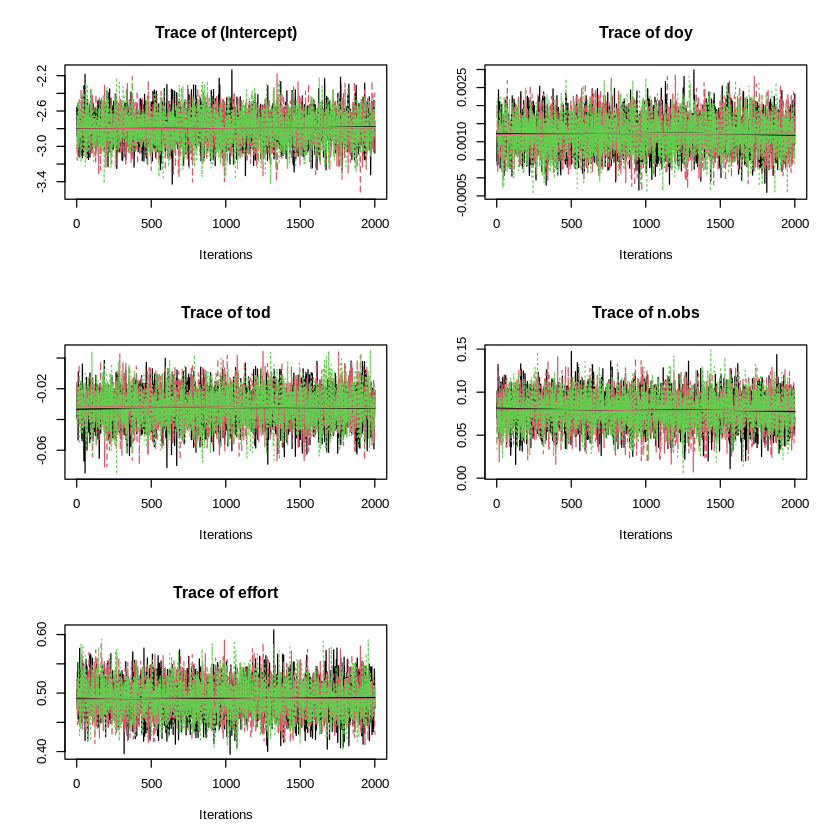

In [53]:
plot(LIVO_occ, 'alpha', density = FALSE) # Detection parameters.

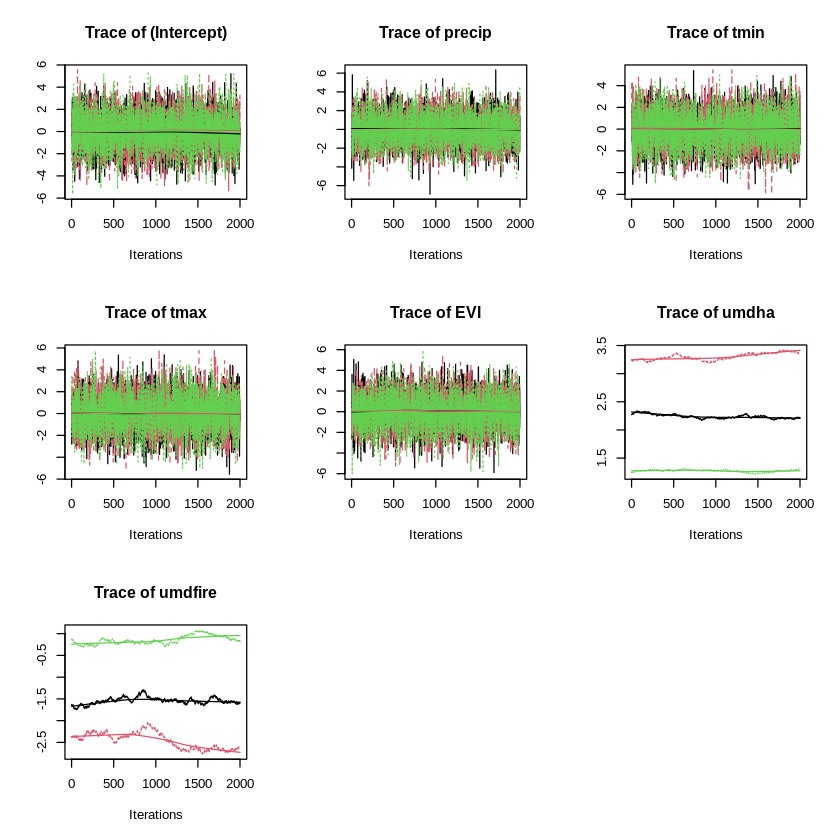

In [54]:
plot(LIVO_occ, 'beta', density = FALSE) # Occupancy parameters.

### Performing posterior predictive checks

From https://doserlab.com/files/spoccupancy-web/articles/modelfitting

The Bayesian p-value is the proportion of posterior samples of the fit statistic of the model generated data that are greater than the corresponding fit statistic of the true data, summed across all “grouped” data points. A Bayesian p-value that hovers around 0.5 indicates adequate model fit, while values less than 0.1 or greater than 0.9 suggest our model does not fit the data well (Hobbs and Hooten 2015).

In [55]:
ppc1.out <- ppcOcc(LIVO_occ, fit.stat = 'chi-squared', group = 1)
summary(ppc1.out)

Currently on time period 1 out of 10

Currently on time period 2 out of 10

Currently on time period 3 out of 10

Currently on time period 4 out of 10

Currently on time period 5 out of 10

Currently on time period 6 out of 10

Currently on time period 7 out of 10

Currently on time period 8 out of 10

Currently on time period 9 out of 10

Currently on time period 10 out of 10




Call:
ppcOcc(object = LIVO_occ, fit.stat = "chi-squared", group = 1)

Samples per Chain: 10000
Burn-in: 2000
Thinning Rate: 4
Number of Chains: 3
Total Posterior Samples: 6000

----------------------------------------
	All time periods combined
----------------------------------------
Bayesian p-value:  0.0014 

----------------------------------------
	Individual time periods
----------------------------------------
Time Period 1 Bayesian p-value: 0
Time Period 2 Bayesian p-value: 0.0012
Time Period 3 Bayesian p-value: 2e-04
Time Period 4 Bayesian p-value: 0.012
Time Period 5 Bayesian p-value: 5e-04
Time Period 6 Bayesian p-value: 0
Time Period 7 Bayesian p-value: 0
Time Period 8 Bayesian p-value: 0
Time Period 9 Bayesian p-value: 0
Time Period 10 Bayesian p-value: 0
Fit statistic:  chi-squared 


In [56]:
ppc2.out <- ppcOcc(LIVO_occ, fit.stat = 'chi-squared', group = 2)
summary(ppc2.out)

Currently on time period 1 out of 10

Currently on time period 2 out of 10

Currently on time period 3 out of 10

Currently on time period 4 out of 10

Currently on time period 5 out of 10

Currently on time period 6 out of 10

Currently on time period 7 out of 10

Currently on time period 8 out of 10

Currently on time period 9 out of 10

Currently on time period 10 out of 10




Call:
ppcOcc(object = LIVO_occ, fit.stat = "chi-squared", group = 2)

Samples per Chain: 10000
Burn-in: 2000
Thinning Rate: 4
Number of Chains: 3
Total Posterior Samples: 6000

----------------------------------------
	All time periods combined
----------------------------------------
Bayesian p-value:  0.7516 

----------------------------------------
	Individual time periods
----------------------------------------
Time Period 1 Bayesian p-value: 0.9557
Time Period 2 Bayesian p-value: 0.0813
Time Period 3 Bayesian p-value: 0.8507
Time Period 4 Bayesian p-value: 0.7832
Time Period 5 Bayesian p-value: 0.9308
Time Period 6 Bayesian p-value: 0.5517
Time Period 7 Bayesian p-value: 0.4608
Time Period 8 Bayesian p-value: 0.9017
Time Period 9 Bayesian p-value: 0.9997
Time Period 10 Bayesian p-value: 1
Fit statistic:  chi-squared 


In [57]:
ppc3.out <- ppcOcc(LIVO_occ, fit.stat = 'freeman-tukey', group = 1)
summary(ppc3.out)

Currently on time period 1 out of 10

Currently on time period 2 out of 10

Currently on time period 3 out of 10

Currently on time period 4 out of 10

Currently on time period 5 out of 10

Currently on time period 6 out of 10

Currently on time period 7 out of 10

Currently on time period 8 out of 10

Currently on time period 9 out of 10

Currently on time period 10 out of 10




Call:
ppcOcc(object = LIVO_occ, fit.stat = "freeman-tukey", group = 1)

Samples per Chain: 10000
Burn-in: 2000
Thinning Rate: 4
Number of Chains: 3
Total Posterior Samples: 6000

----------------------------------------
	All time periods combined
----------------------------------------
Bayesian p-value:  0.0047 

----------------------------------------
	Individual time periods
----------------------------------------
Time Period 1 Bayesian p-value: 0.0027
Time Period 2 Bayesian p-value: 2e-04
Time Period 3 Bayesian p-value: 0.0097
Time Period 4 Bayesian p-value: 0.0295
Time Period 5 Bayesian p-value: 5e-04
Time Period 6 Bayesian p-value: 0.0042
Time Period 7 Bayesian p-value: 3e-04
Time Period 8 Bayesian p-value: 2e-04
Time Period 9 Bayesian p-value: 2e-04
Time Period 10 Bayesian p-value: 0
Fit statistic:  freeman-tukey 


In [58]:
ppc4.out <- ppcOcc(LIVO_occ, fit.stat = 'freeman-tukey', group = 2)
summary(ppc4.out)

Currently on time period 1 out of 10

Currently on time period 2 out of 10

Currently on time period 3 out of 10

Currently on time period 4 out of 10

Currently on time period 5 out of 10

Currently on time period 6 out of 10

Currently on time period 7 out of 10

Currently on time period 8 out of 10

Currently on time period 9 out of 10

Currently on time period 10 out of 10




Call:
ppcOcc(object = LIVO_occ, fit.stat = "freeman-tukey", group = 2)

Samples per Chain: 10000
Burn-in: 2000
Thinning Rate: 4
Number of Chains: 3
Total Posterior Samples: 6000

----------------------------------------
	All time periods combined
----------------------------------------
Bayesian p-value:  0.7594 

----------------------------------------
	Individual time periods
----------------------------------------
Time Period 1 Bayesian p-value: 0.9972
Time Period 2 Bayesian p-value: 0.008
Time Period 3 Bayesian p-value: 0.4762
Time Period 4 Bayesian p-value: 0.8555
Time Period 5 Bayesian p-value: 0.768
Time Period 6 Bayesian p-value: 0.891
Time Period 7 Bayesian p-value: 0.9772
Time Period 8 Bayesian p-value: 0.6267
Time Period 9 Bayesian p-value: 0.9963
Time Period 10 Bayesian p-value: 0.998
Fit statistic:  freeman-tukey 


Posterior predictive checks binned along replicates has a better Bayesian p value (closer to 0.5) indicating that the model fails to adequately represent variation in detection and occurrence probability across sites.

Visualizing the Bayesian p-value with the Freeman-Tukey fit statistic for data grouped along replicates

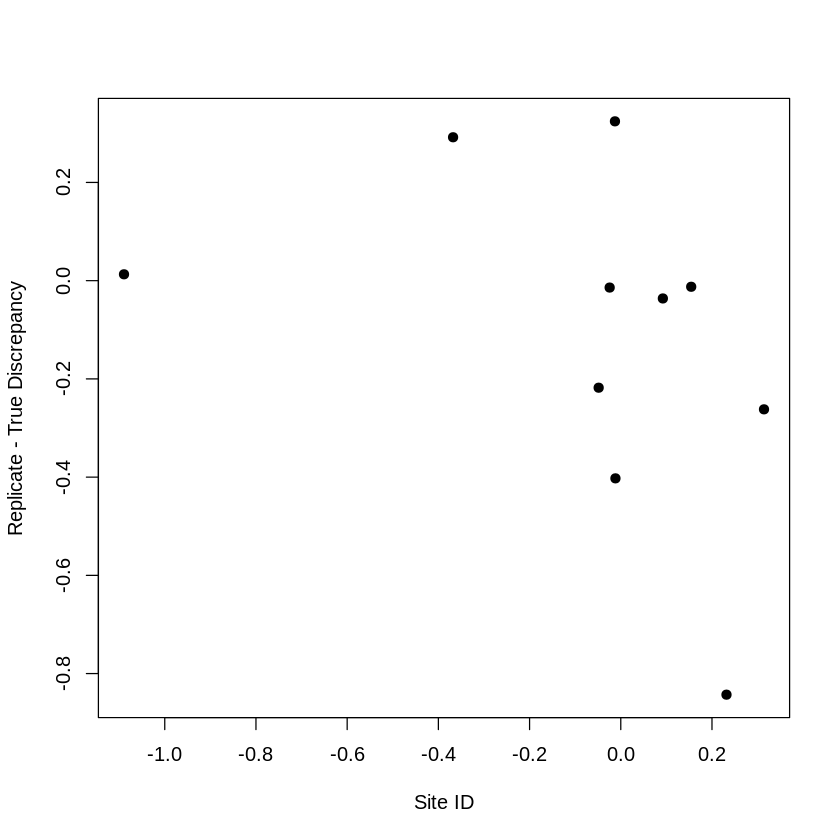

In [59]:
diff.fit <- ppc4.out$fit.y.rep.group.quants[3, , ] - ppc4.out$fit.y.group.quants[3, , ]
plot(diff.fit, pch = 19, xlab = 'Site ID', ylab = 'Replicate - True Discrepancy')

In [60]:
waicOcc(LIVO_occ) #Widely Applicable Information Criterion

elpd         pD       WAIC 
-1512.7991    24.4016  3074.4013

Modeling with stPGOcc (Single-species multi-season spatio-temporal occupancy model) - includes spatial effects (across sites in Manaus) as well as the temporal effects across years

In [37]:
LIVO_occ_spatial <- stPGOcc(occ.formula = LIVO.occ.formula, #occupancy formula
                      det.formula = LIVO.det.formula, #detection formula
                      data = data.ssom, #dataset
                      n.batch = 400, #MCMC - number of batches
                      batch.length = 25, #MCMC - length of each batch
                      accept.rate = 0.43, #target acceptance rate of the MCMC
                      cov.model = "gaussian", #spatial covariance model
                      NNGP = TRUE, #using nearest neighbor gaussian process
                      n.neighbors = 5, #number of neighbors for NNGP
                      n.burn = 2000, #number of burn-in samples
                      n.thin = 4, #thinning rate
                      n.chains = 3, #number of MCMC chains
                      verbose = TRUE #verbose output
                      )

----------------------------------------
	Preparing the data
----------------------------------------


No prior specified for beta.normal.
Setting prior mean to 0 and prior variance to 2.72


No prior specified for alpha.normal.
Setting prior mean to 0 and prior variance to 2.72


No prior specified for phi.unif.
Setting uniform bounds based on the range of observed spatial coordinates.


No prior specified for sigma.sq.
Using an inverse-Gamma prior with the shape parameter set to 2 and scale parameter to 1.


z is not specified in initial values.
Setting initial values based on observed data


beta is not specified in initial values.
Setting initial values to random values from the prior distribution


alpha is not specified in initial values.
Setting initial values to random values from the prior distribution


phi is not specified in initial values.
Setting initial value to random value from the prior distribution


sigma.sq is not specified in initial values.
Setting initial value to random value from the prior distribution




----------------------------------------
	Building the neighbor list
----------------------------------------
----------------------------------------
Building the neighbors of neighbors list
----------------------------------------
----------------------------------------
	Model description
----------------------------------------
Spatial NNGP Multi-season Occupancy Model with Polya-Gamma latent
variable fit with 4 sites and 10 primary time periods.

Samples per chain: 10000 (400 batches of length 25)
Burn-in: 2000 
Thinning Rate: 4 
Number of Chains: 3 
Total Posterior Samples: 6000 

Using the gaussian spatial correlation model.

Using 5 nearest neighbors.

Source compiled with OpenMP support and model fit using 1 thread(s).

Adaptive Metropolis with target acceptance rate: 43.0
----------------------------------------
	Chain 1
----------------------------------------
Sampling ... 
Batch: 100 of 400, 25.00%
	Parameter	Acceptance	Tuning
	phi		68.0		2.69123
---------------------------

In [38]:
names(LIVO_occ_spatial)

[1] "rhat"           "beta.samples"   "alpha.samples"  "theta.samples" 
 [5] "coords"         "X"              "X.re"           "w.samples"     
 [9] "z.samples"      "psi.samples"    "like.samples"   "y"             
[13] "X.p"            "X.p.re"         "ESS"            "call"          
[17] "n.samples"      "n.neighbors"    "cov.model.indx" "type"          
[21] "n.post"         "n.thin"         "n.burn"         "n.chains"      
[25] "ar1"            "pRE"            "psiRE"          "run.time"

In [39]:
summary(LIVO_occ_spatial)


Call:
stPGOcc(occ.formula = LIVO.occ.formula, det.formula = LIVO.det.formula, 
    data = data.ssom, cov.model = "gaussian", NNGP = TRUE, n.neighbors = 5, 
    n.batch = 400, batch.length = 25, accept.rate = 0.43, verbose = TRUE, 
    n.burn = 2000, n.thin = 4, n.chains = 3)

Samples per Chain: 10000
Burn-in: 2000
Thinning Rate: 4
Number of Chains: 3
Total Posterior Samples: 6000
Run Time (min): 1.1208

Occurrence (logit scale): 
               Mean     SD    2.5%     50%   97.5%     Rhat  ESS
(Intercept) -0.0091 1.6471 -3.1713 -0.0237  3.2516   1.0006 6000
precip      -0.0159 1.6465 -3.2822 -0.0227  3.2465   1.0019 5488
tmin        -0.0135 1.6502 -3.2164 -0.0158  3.1408   1.0003 5735
tmax         0.0008 1.6415 -3.2937  0.0299  3.1807   1.0010 6000
EVI          0.0283 1.6639 -3.2164  0.0036  3.2464   1.0009 6000
umdha        1.7161 0.8170  0.6055  1.9053  2.6753 118.0151    2
umdfire     -1.2706 0.7207 -2.6054 -0.8055 -0.6336  30.2825    2

Detection (logit scale): 
               Mea

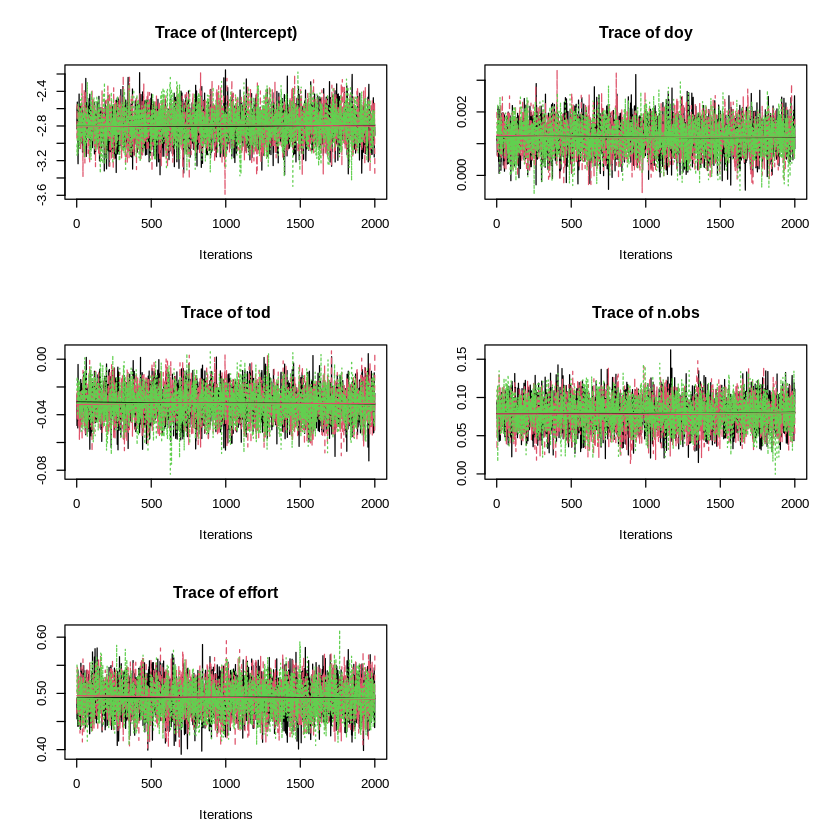

In [40]:
plot(LIVO_occ_spatial, 'alpha', density = FALSE) # Detection parameters.

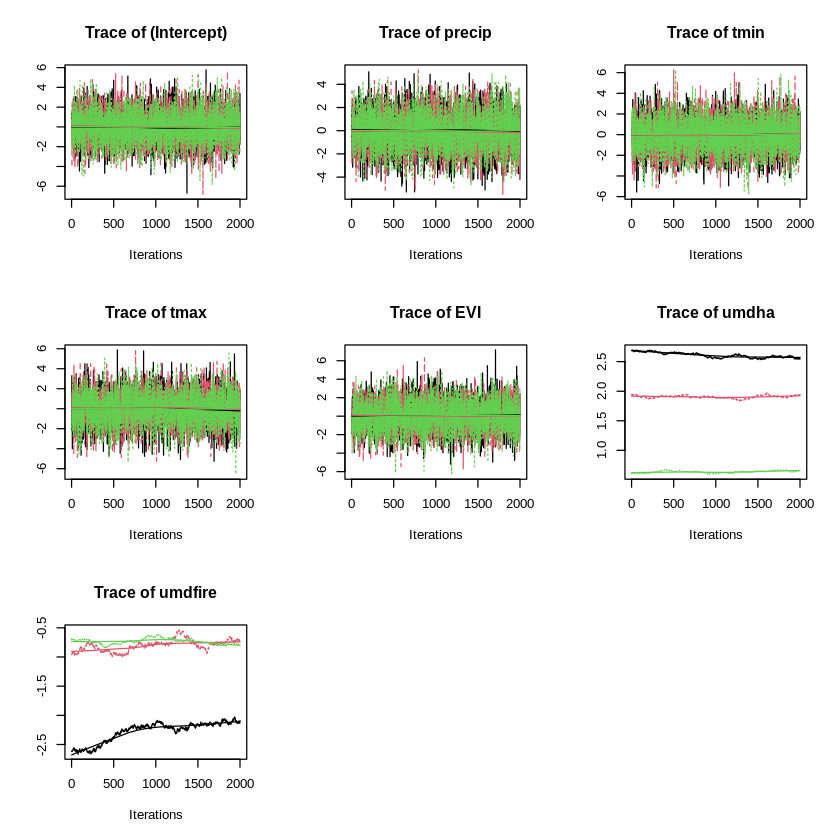

In [41]:
plot(LIVO_occ_spatial, 'beta', density = FALSE) # Occupancy parameters.

### Performing posterior predictive checks for stPGOcc

In [42]:
ppc.spatial_1.out <- ppcOcc(LIVO_occ_spatial, fit.stat = 'chi-squared', group = 1)
summary(ppc.spatial_1.out)

Currently on time period 1 out of 10

Currently on time period 2 out of 10

Currently on time period 3 out of 10

Currently on time period 4 out of 10

Currently on time period 5 out of 10

Currently on time period 6 out of 10

Currently on time period 7 out of 10

Currently on time period 8 out of 10

Currently on time period 9 out of 10

Currently on time period 10 out of 10




Call:
ppcOcc(object = LIVO_occ_spatial, fit.stat = "chi-squared", group = 1)

Samples per Chain: 10000
Burn-in: 2000
Thinning Rate: 4
Number of Chains: 3
Total Posterior Samples: 6000

----------------------------------------
	All time periods combined
----------------------------------------
Bayesian p-value:  0.0016 

----------------------------------------
	Individual time periods
----------------------------------------
Time Period 1 Bayesian p-value: 2e-04
Time Period 2 Bayesian p-value: 7e-04
Time Period 3 Bayesian p-value: 8e-04
Time Period 4 Bayesian p-value: 0.0142
Time Period 5 Bayesian p-value: 3e-04
Time Period 6 Bayesian p-value: 0
Time Period 7 Bayesian p-value: 0
Time Period 8 Bayesian p-value: 0
Time Period 9 Bayesian p-value: 0
Time Period 10 Bayesian p-value: 0
Fit statistic:  chi-squared 


In [43]:
ppc_spatial_2.out <- ppcOcc(LIVO_occ_spatial, fit.stat = 'chi-squared', group = 1)
summary(ppc_spatial_2.out)

Currently on time period 1 out of 10

Currently on time period 2 out of 10

Currently on time period 3 out of 10

Currently on time period 4 out of 10

Currently on time period 5 out of 10

Currently on time period 6 out of 10

Currently on time period 7 out of 10

Currently on time period 8 out of 10

Currently on time period 9 out of 10

Currently on time period 10 out of 10




Call:
ppcOcc(object = LIVO_occ_spatial, fit.stat = "chi-squared", group = 1)

Samples per Chain: 10000
Burn-in: 2000
Thinning Rate: 4
Number of Chains: 3
Total Posterior Samples: 6000

----------------------------------------
	All time periods combined
----------------------------------------
Bayesian p-value:  0.0014 

----------------------------------------
	Individual time periods
----------------------------------------
Time Period 1 Bayesian p-value: 2e-04
Time Period 2 Bayesian p-value: 2e-04
Time Period 3 Bayesian p-value: 7e-04
Time Period 4 Bayesian p-value: 0.012
Time Period 5 Bayesian p-value: 0.0015
Time Period 6 Bayesian p-value: 0
Time Period 7 Bayesian p-value: 0
Time Period 8 Bayesian p-value: 0
Time Period 9 Bayesian p-value: 0
Time Period 10 Bayesian p-value: 0
Fit statistic:  chi-squared 


In [44]:
ppc_spatial_3.out <- ppcOcc(LIVO_occ_spatial, fit.stat = 'chi-squared', group = 1)
summary(ppc_spatial_3.out)

Currently on time period 1 out of 10

Currently on time period 2 out of 10

Currently on time period 3 out of 10

Currently on time period 4 out of 10

Currently on time period 5 out of 10

Currently on time period 6 out of 10

Currently on time period 7 out of 10

Currently on time period 8 out of 10

Currently on time period 9 out of 10

Currently on time period 10 out of 10




Call:
ppcOcc(object = LIVO_occ_spatial, fit.stat = "chi-squared", group = 1)

Samples per Chain: 10000
Burn-in: 2000
Thinning Rate: 4
Number of Chains: 3
Total Posterior Samples: 6000

----------------------------------------
	All time periods combined
----------------------------------------
Bayesian p-value:  0.0015 

----------------------------------------
	Individual time periods
----------------------------------------
Time Period 1 Bayesian p-value: 0
Time Period 2 Bayesian p-value: 0.0015
Time Period 3 Bayesian p-value: 5e-04
Time Period 4 Bayesian p-value: 0.0122
Time Period 5 Bayesian p-value: 5e-04
Time Period 6 Bayesian p-value: 0
Time Period 7 Bayesian p-value: 0
Time Period 8 Bayesian p-value: 0
Time Period 9 Bayesian p-value: 0
Time Period 10 Bayesian p-value: 0
Fit statistic:  chi-squared 


In [45]:
ppc_spatial_4.out <- ppcOcc(LIVO_occ_spatial, fit.stat = 'chi-squared', group = 1)
summary(ppc_spatial_4.out)

Currently on time period 1 out of 10

Currently on time period 2 out of 10

Currently on time period 3 out of 10

Currently on time period 4 out of 10

Currently on time period 5 out of 10

Currently on time period 6 out of 10

Currently on time period 7 out of 10

Currently on time period 8 out of 10

Currently on time period 9 out of 10

Currently on time period 10 out of 10




Call:
ppcOcc(object = LIVO_occ_spatial, fit.stat = "chi-squared", group = 1)

Samples per Chain: 10000
Burn-in: 2000
Thinning Rate: 4
Number of Chains: 3
Total Posterior Samples: 6000

----------------------------------------
	All time periods combined
----------------------------------------
Bayesian p-value:  0.0016 

----------------------------------------
	Individual time periods
----------------------------------------
Time Period 1 Bayesian p-value: 0
Time Period 2 Bayesian p-value: 0.0013
Time Period 3 Bayesian p-value: 7e-04
Time Period 4 Bayesian p-value: 0.013
Time Period 5 Bayesian p-value: 8e-04
Time Period 6 Bayesian p-value: 0
Time Period 7 Bayesian p-value: 0
Time Period 8 Bayesian p-value: 0
Time Period 9 Bayesian p-value: 0
Time Period 10 Bayesian p-value: 0
Fit statistic:  chi-squared 


In [46]:
waicOcc(LIVO_occ_spatial) #Widely Applicable Information Criterion

elpd          pD        WAIC 
-1513.34901    23.66753  3074.03307